# Methods for momentum inversion

By George Lu

Last updated: April 22, 2025

The goal of this notebook is to walk through the logic and math for my momentum conservation inversion. I will define all the relevant math within this notebook, and copy the relevant code from their files directly into this notebook so I can explain it. This notebook assumes that the ground truth data is correct, and aims to identify potential errors in the momentum conservation inversion

## Equations to solve
We start with the momentum balance derived from Stokes equations in a 2D x-z plane, assuming that there is no flow in the y-direction:
\begin{equation}
    \frac{\partial}{\partial x}\left(2\mu\frac{\partial u}{\partial x}\right) + \frac{\partial}{\partial z}\left(\mu\frac{\partial u}{\partial z}+\mu\frac{\partial w}{\partial x}\right) - \frac{\partial p}{\partial x} = 0,
\end{equation}
\begin{equation}
    \frac{\partial}{\partial x}\left(\mu\frac{\partial u}{\partial z}+\mu\frac{\partial w}{\partial x}\right) +\frac{\partial}{\partial z}\left(2\mu\frac{\partial w}{\partial z}\right) - \frac{\partial p}{\partial z} - \rho g = 0.
\end{equation}

After obtaining $u$, $w$, $\rho$ from the mass conservation PINN, we can preserve their scalings, which are:
$$u=u'w_r, w=w'w_r+w_m, \rho = \rho' \rho_i $$
We also set a scaling for the pressure to be equivalent to $p=p'\rho_i g z_r$. Our scalings for x and z also remain the same. Only $\mu=\mu'\mu_r$ has an unknown scaling term. Currently, we set $\mu_r = \exp(\overline{\log(\mu_f)})$, where $\overline{\log(\mu_f)}$ is the mean of the natural logarithm of the values of $\mu$ at the left and right hand flanks.

After subbing in our dimensionless values, the momentum balance equations become:
\begin{equation}
    \frac{\partial}{\partial x'x_r}\left(2\mu'\mu_r\frac{\partial u'w_r}{\partial x'x_r}\right) + \frac{\partial}{\partial z'z_r}\left(\mu'\mu_r\frac{\partial u'w_r}{\partial z'z_r}+\mu'\mu_r\frac{\partial w'w_r}{\partial x'x_r}\right) - \frac{\partial p'\rho_i g z_r}{\partial x'x_r} = 0,
\end{equation}
\begin{equation}
    \frac{\partial}{\partial x'x_r}\left(\mu'\mu_r\frac{\partial u'w_r}{\partial z'z_r}+\mu'\mu_r\frac{\partial w'w_r}{\partial x'x_r}\right) +\frac{\partial}{\partial z'z_r}\left(2\mu'\mu_r\frac{\partial w'w_r}{\partial z'z_r}\right) - \frac{\partial p'\rho_i g z_r}{\partial z'z_r} - \rho'\rho_i g = 0.
\end{equation}
Collecting the terms, the equations become:
\begin{equation}
    \frac{2\mu_rw_r}{x_r^2}\frac{\partial}{\partial x'}\left(\mu'\frac{\partial u'}{\partial x'}\right) + \frac{\mu_rw_r}{z_r}\frac{\partial}{\partial z'}\left(\frac{\mu'}{z_r}\frac{\partial u'}{\partial z'}+\frac{\mu'}{x_r}\frac{\partial w'}{\partial x'}\right) - \frac{\rho_igz_r}{x_r}\frac{\partial p'}{\partial x'} = 0,
\end{equation}
\begin{equation}
    \frac{\mu_rw_r}{x_r}\frac{\partial}{\partial x'}\left(\frac{\mu'}{z_r}\frac{\partial u'}{\partial z'}+\frac{\mu'}{x_r}\frac{\partial w'}{\partial x'}\right) + \frac{2\mu_rw_r}{z_r^2}\frac{\partial}{\partial z'}\left(\mu'\frac{\partial w'}{\partial z'}\right) - \rho_ig\left(\frac{\partial p' }{\partial z'} + \rho'\right) = 0.
\end{equation}

Let's try dividing through by the scale terms in front of the pressure term. 
\begin{equation}
    \frac{2\mu_rw_r}{\rho_i g z_rx_r}\frac{\partial}{\partial x'}\left(\mu'\frac{\partial u'}{\partial x'}\right) + \frac{\mu_rw_rx_r}{\rho_i g z_r^2}\frac{\partial}{\partial z'}\left(\frac{\mu'}{z_r}\frac{\partial u'}{\partial z'}+\frac{\mu'}{x_r}\frac{\partial w'}{\partial x'}\right) - \frac{\partial p'}{\partial x'} = 0,
\end{equation}
\begin{equation}
    \frac{\mu_rw_r}{\rho_igx_r}\frac{\partial}{\partial x'}\left(\frac{\mu'}{z_r}\frac{\partial u'}{\partial z'}+\frac{\mu'}{x_r}\frac{\partial w'}{\partial x'}\right) + \frac{2\mu_rw_r}{\rho_igz_r^2}\frac{\partial}{\partial z'}\left(\mu'\frac{\partial w'}{\partial z'}\right) - \left(\frac{\partial p' }{\partial z'} + \rho'\right) = 0.
\end{equation}

These equations are the ones implemented in the code. An example momentum inversion with these equations is shown below.


In [1]:
# Importing relevant libraries
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax.numpy as jnp
from jax import random
from jax.tree_util import tree_map
from scipy.io import loadmat
import time

The next snippet of code loads in the FEniCS data. It is generated using the `FEniCS_divide_test.ipynb` notebook, and the variables for $x$, $z$, $u$, $w$, $\rho$, $p$, $\mu$, and $d$ (for depth) are saved into a csv file that can be read with the `load_fenics_results` function. 

In [3]:
# defining function to load in FEniCS data
# still need to check if the ground truth satisfies the physics
def load_fenics_results(csv, x_left=-2000, x_right=2000):
    df = pd.read_csv(f'{csv}')
    
    # Keep full df for interpolation, use filtered for main body
    df_filtered = df[(df['x'] > x_left) & (df['x'] < x_right)]
    df_surface = df_filtered[df_filtered['d'] <= 1e-6] # to account for a lack of d=0.0 because depth is calculated by subtracting z_mesh from surface function calculated using xmesh

    new_rows = []

    # Interpolate at the divide (x = 0)
    for z_val in sorted(df['z'].unique()):
        df_z = df[df['z'] == z_val]
        if df_z['x'].min() <= 0 <= df_z['x'].max():
            df_z = df_z.sort_values('x')
            new_row = {
                'x': 0,
                'z': z_val,
            }
            for col in ['u', 'w', 'rho', 'p', 'mu', 'd']:
                new_row[col] = np.interp(0, df_z['x'], df_z[col])
            new_rows.append(new_row)

    df_interp = pd.DataFrame(new_rows)
    df_combined = pd.concat([df_filtered, df_interp], ignore_index=True)
    df_divide = df_combined[df_combined['x'] == 0]

    # Interpolate at flanks (using the full df!)
    flank_rows = []
    for x_target in [x_left, x_right]:
        for z_val in sorted(df['z'].unique()):
            df_z = df[df['z'] == z_val]
            if df_z['x'].min() <= x_target <= df_z['x'].max():
                df_z = df_z.sort_values('x')
                row = {
                    'x': x_target,
                    'z': z_val,
                }
                for col in ['u', 'w', 'rho', 'p', 'mu', 'd']:
                    row[col] = np.interp(x_target, df_z['x'], df_z[col])
                flank_rows.append(row)
    df_flanks = pd.DataFrame(flank_rows)

    df_bed = df_filtered[df_filtered['z'] == 0]

    return df_filtered, df_surface, df_divide, df_bed, df_flanks

The outputted results are all pandas dataframes. There is a dataframe for all the boundaries, in addition to throughout the domain. The dataframes are set up such that they always contain values for all five key variables: $u$, $w$, $\rho$, $p$, $\mu$. If we don't have data for these variables, the load data function must assign some placeholder. We need to ensure that when we calculate losses, we are not accidentally comparing predicted results to this dummy placeholder data. 

In [10]:
df_full, df_surf, df_divide, df_bed, df_flanks = load_fenics_results('data_processing/fenics_data.csv')

Now, we normalize each of these dataframes. I have defined a function that works on any data, so long it is processed into these five dataframes containing the five key variables and their coordinates. This function is saved in `data_processsing/helpers.py`.

In [18]:
def normalize(df_filtered, df_surface, df_divide, df_bed, df_flanks):
    # keys that will always be there
    x = df_filtered['x'].values
    z = df_filtered['z'].values
    w = df_filtered['w'].values
    
    rho_bed = df_bed['rho'].values.mean()
    mu_flanks = df_flanks['mu'].values
    
    # assign scales - use a dict
    means_and_scales = {}
    means_and_scales['x_mean'] = jnp.mean(x)
    means_and_scales['x_range'] = (x.max() - x.min()) / 2
    means_and_scales['z_mean'] = jnp.mean(z)
    means_and_scales['z_range'] = (z.max() - z.min()) / 2
    means_and_scales['w_mean'] = jnp.mean(w)
    means_and_scales['w_range'] = jnp.std(w) * 2
    # the divide assumes that u will vary around 0
    means_and_scales['u_mean'] = 0
    means_and_scales['u_range'] = jnp.std(w) * 2 # same as w_range
    # let's say the ice scaling is that of glacial ice (elmer uses 910)
    # let's also say the pressure scale is dependent on ice thickness
    means_and_scales['rho_range'] = rho_bed
    means_and_scales['rho_mean'] = 0
    means_and_scales['p_range'] = means_and_scales['rho_range']*9.81*means_and_scales['z_range'] # this also assumes not centered at 0 
    means_and_scales['p_mean'] = 0
    means_and_scales['mu_range'] = jnp.exp(jnp.nanmean(jnp.log(jnp.abs(mu_flanks))))
    means_and_scales['mu_mean'] = 0

    #norm_list
    df_full_norm,df_surf_norm,df_div_norm,df_bed_norm,df_flanks_norm = pd.DataFrame([]),pd.DataFrame([]),pd.DataFrame([]),pd.DataFrame([]),pd.DataFrame([])
    
    for key in ['x','z','u','w','rho','p','mu']:
        for df,df_norm in zip([df_filtered,df_surface, df_divide, df_bed, df_flanks],[df_full_norm,df_surf_norm,df_div_norm,df_bed_norm,df_flanks_norm]):
            df_norm[key] = (df[key] - means_and_scales[f'{key}_mean'])/means_and_scales[f'{key}_range']
    return df_full_norm,[df_surf_norm,df_div_norm,df_bed_norm,df_flanks_norm],means_and_scales


In the above code, we've assigned values of zero to some of the means, since some of our scalings are only by range ($u$, $\rho$, $p$, $\mu$). I want to highlight a potential concern - the scalings for $u$ assume symmetry, which should be OK for the divide, but is not applicable away from it. Additionally, the normalized values for most variables vary from -1 to 1, but those of $\rho$, $p$ and $\mu$ do not. 

In [17]:
df_norm,df_bcs,info = normalize(df_full, df_surf, df_divide, df_bed, df_flanks)
# df_bcs is a list containing the data for surface, divide, bed and flanks

Now that we have our scaled values, we can sample them for the PINN. The generalized function `sample()` in `data_processsing/helpers.py` works with any normalized dataframe outputted by `normalize()`.

In [19]:
def sample(df_norm,n_samples,df_bcs):
    # df_norm is the dataframe of interest
    # key is the rng key that we set for reproducibility 
    # n_samples is a list including number of samples, followed by number of colocation points
    def dataf(key):
        keys = random.split(key, 2) 
        X_star = df_norm[['x','z']].values
        U_star = df_norm[['u','w','rho','p','mu']].values
        n_data = X_star.shape[0]    
        idx_smp = random.choice(keys[0], jnp.arange(n_data), [n_samples[0]])
        X_smp = X_star[idx_smp,:]
        U_smp = U_star[idx_smp,:]
    
        idx_col = random.choice(keys[1], jnp.arange(n_data), [n_samples[1]])
        X_col = X_star[idx_col,:]
        U_col = U_star[idx_col,:]
        data = dict(smp=[X_smp,U_smp],col=[X_col,U_col])

        # add in bcs - currently, include all data
        for dict_key, df_bc in zip(['surf','div','bed','flanks'],df_bcs):
            X_bc = df_bc[['x','z']].values
            U_bc = df_bc[['u','w','rho','p','mu']].values
            data[dict_key] = [X_bc,U_bc]
        
        return data
    return dataf


Right now, in my other notebooks, the below cell is used to sample the data. I call it after intializing the PINN, typically.

In [20]:
# now we sample
# select a random seed
seed = 1234 #2134
key = random.PRNGKey(seed)
np.random.seed(seed)

# create the subkeys
keys = random.split(key, 4) 
# for adam
n_samples = jnp.array([200,200]) # small number for now
dataf = sample(df_norm,n_samples,df_bcs) # nsamples is for data loss + colocation points
keys_adam = random.split(keys[1], 5)
data = dataf(keys_adam[0])

# for L-BFGS
n_pt2 = n_samples * 2
dataf_l = sample(df_norm, n_pt2,df_bcs)
key_lbfgs = random.split(keys[2], 5)

Now, we initalize the PINN. This is mostly unchanged from the `DIFFICE_JAX` scripts. However, my PINN is set up such that it can be used for either mass conservation and/or momentum conservation. It consequently solves for the parameters for the exponential $\rho$ function, rather than $\rho$ directly. These functions are all found in  `models/initialization.py`. 

In [21]:
from jax import random
import jax.numpy as jnp

# define the basic formation of neural network
def neural_net(params, x, scl, act_s=0):
    '''
    :param params: weights and biases
    :param x: input data [matrix with shape [N, m]]; m is number of inputs)
    :param sgn:  1 for even function and -1 for odd function
    :return: neural network output [matrix with shape [N, n]]; n is number of outputs)
    '''
    # choose the activation function
    actv = [jnp.tanh, jnp.sin][act_s]
    # normalize the input
    H = x  # input has been normalized
    # separate the first, hidden and last layers
    first, *hidden, last = params
    # calculate the first layers output with right scale
    H = actv(jnp.dot(H, first[0]) * scl + first[1])
    # calculate the middle layers output
    for layer in hidden:
        H = jnp.tanh(jnp.dot(H, layer[0]) + layer[1])
    # no activation function for last layer
    var = jnp.dot(H, last[0]) + last[1]
    return var
    
# initialize single network
def init_single_net(parent_key, layer_widths):
    params = []
    keys = random.split(parent_key, num=len(layer_widths) - 1)
    # create the weights and biases for the network
    for in_dim, out_dim, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = random.split(key)
        xavier_stddev = jnp.sqrt(2 / (in_dim + out_dim))
        params.append(
            [random.truncated_normal(weight_key, -2, 2, shape=(in_dim, out_dim)) * xavier_stddev,
             random.truncated_normal(bias_key, -2, 2, shape=(out_dim,)) * 0]
        )
    return params

def init_pinns(parent_key, n_hl, n_unit): 
    # This should be general! Try to get solution/loss functions to adapt to this
    '''
    :param n_hl: number of hidden layers [int]
    :param n_unit: number of units in each layer [int]
    '''

    # set the neural network shape for u, w
    layers1 = [2] + n_hl * [n_unit] + [2] 

    # set the neural network shape for p, mu
    layers2 = [2] + n_hl * [n_unit] + [2] 

    # generate the random key for each network
    keys = random.split(parent_key, 3)
    
    # generate weights and biases for density
    params_uw = init_single_net(keys[0], layers1)
    params_pmu = init_single_net(keys[1], layers2)

    params_rho = random.truncated_normal(keys[2], -2, 2, shape=(2,)) # 2 params rho_s and L

    return [params_uw, params_rho, params_pmu]

We keep the number of hidden layers and the number of units the same as before.

In [22]:
n_hl = 6
n_unit = 30
# initialize the weights and biases of the network
trained_params = init_pinns(keys[0], n_hl, n_unit)

Now we create the solution function. The function below that does this is also in `models/initialization.py`. Note here, we are forcing `pmu` (pressure and viscosity) to be positive by putting it into an exponential. 

In [23]:
def create_solution(df_surf,scl=1, act_s=0):
    # this should also be a general function!
    # df_surf is nondimensional
    x_s = df_surf['x'].values
    z_s = df_surf['z'].values
    
    def f(params,x):
        x0, z0 = jnp.split(x, 2, axis=1)
        uw = neural_net(params[0], x, scl, act_s)
        pm_rho = params[1]
        H = jnp.interp(x0,x_s,z_s)  
        rho = 1 + (jnp.exp(pm_rho[0]) - 1) * jnp.exp((-H+z0)/jnp.exp(pm_rho[1]))
        pmu = neural_net(params[2], x, scl, act_s)
        sol = jnp.hstack([uw,rho,jnp.exp(pmu)])
        return sol
    return f

In [24]:
pred_u = create_solution(df_bcs[0]) # need to modify as well


In preparation for making the loss function, we define the governing equation for momentum conservation. This is defined in `equations/momentum_conservation.py`. It calls on the functions `vgmat()` and `vectgrad()`, which are unchanged from `DIFFICE_JAX` and found in `equations/gradients`. Here is where we implement the equations defined at the start of the notebook. 

In [29]:
import jax.numpy as jnp
from jax import vjp, vmap, lax

def vgmat(x, n_out, idx=None):
    '''
    :param n_out: number of output variables
    :param idx: indice (list) of the output variable to take the gradient
    '''
    if idx is None:
        idx = range(n_out)
    # obtain the number of index
    n_idx = len(idx)
    # obtain the number of input points
    n_pt = x.shape[0]
    # determine the shape of the gradient matrix
    mat_shape = [n_idx, n_pt, n_out]
    # create the zero matrix based on the shape
    mat = jnp.zeros(mat_shape)
    # choose the associated element in the matrix to 1
    for l, ii in zip(range(n_idx), idx):
        mat = mat.at[l, :, ii].set(1.)
    return mat


# vector gradient of the output with input
def vectgrad(func, x):
    # obtain the output and the gradient function
    sol, vjp_fn = vjp(func, x)
    # determine the mat grad
    mat = vgmat(x, sol.shape[1])
    # calculate the gradient of each output with respect to each input
    grad0 = vmap(vjp_fn, in_axes=0)(mat)[0]
    # calculate the total partial derivative of output with input
    n_pd = x.shape[1] * sol.shape[1]
    # reshape the derivative of output with input
    grad = grad0.transpose(1, 0, 2)
    grad_all = grad.reshape(x.shape[0], n_pd)
    return grad_all, sol

def gov_eqn(net, x, scales):
    # get scales
    x0 = scales['x_range']
    z0 = scales['z_range']
    w0 = scales['w_range']
    mu0 = scales['mu_range']

    def grad1stOrder(net, x):
        grad, sol = vectgrad(net, x)
        # order should u w rho p mu
        rho = sol[:, 2:3]
        mu = sol[:,4:5]

        u_x = grad[:, 0:1]
        u_z = grad[:, 1:2]
        w_x = grad[:, 2:3]
        w_z = grad[:, 3:4]
        # rho_x, rho_z for 4:5, 5:6
        p_x = grad[:, 6:7]
        p_z = grad[:, 7:8]

        term1_1 = mu*u_x
        term12_21 = mu*(u_z/z0 + w_x/x0 )
        term1_3 = p_x

        term2_2 = mu*w_z
        term2_3 = p_z + rho

        return jnp.hstack([term1_1,term12_21,term1_3,term2_2,term2_3])

    func_g = lambda x: grad1stOrder(net, x)
    grad_term, term = vectgrad(func_g, x)
    
    e1term1 = 2*mu0*w0*grad_term[:, 0:1]/(910*9.81*z0*x0) # (term1_1,x)
    e1term2 = mu0*w0*x0*grad_term[:,3:4]/(910*9.81*z0**2) # (term12_21,z)
    e1term3 = term[:,2:3]
    e2term1 = mu0*w0*grad_term[:,2:3]/(910*9.81*x0) # (term12_21,x)
    e2term2 = 2*mu0*w0*grad_term[:,7:8]/(910*9.81*z0**2)
    e2term3 = term[:,4:5]

    e1 = e1term1 + e1term2 - e1term3
    e2 = e2term1 + e2term2 - e2term3
    f_eqn = jnp.hstack([e1, e2])
    terms = jnp.hstack([e1term1, e1term2, e1term3, e2term1, e2term2, e2term3])
    return f_eqn, terms

Next, we define the loss function. This cell is custom to each model notebook. It's important that the right variables are properly indexed in this function (and also the governing equations). The loss function is what we use to address all of our boundary conditions. I intend to treat any given boundary condition for this problem as another data loss, but at the boundary. When we eventually get around to paramaterizing $\mu$, we can define the flanks dataframe such that the $\mu$ column contains paramaterized values. 

In [30]:
def ms_error(diff):
    return jnp.mean(jnp.square(diff), axis=0)

def create_loss_momentum(predf,gov_eqn,scales,lw,alldata=False):
    # for now do 3 lw weights: data, eqn, bc
    def loss_fun(params, data):
        # create the function for gradient calculation involves input Z only
        net = lambda z: predf(params, z)
        
        # load the ground truth for dataloss
        x_smp = data['smp'][0]
        if alldata:
            U_smp = data['smp'][1][:,0:5] # include p and mu in training data
        else:
            U_smp = data['smp'][1][:,0:3] # ground truth u,w,rho 
        # assuming only surface ice pressure is known
        x_surf = data['surf'][0]
        p_surf = data['surf'][1][:,3:4] # ground truth surface ice pressure
        
        # assuming known viscosities at flanks
        x_flanks = data['flanks'][0]
        mu_flanks = data['flanks'][1][:,4:5] # doing viscosities at flank

        # load the position and weight of collocation points
        x_col = data['col'][0]

        # calculate the predicted variables
        if alldata:
            U_pred = net(x_smp)[:, 0:5]
        else: 
            U_pred = net(x_smp)[:, 0:3] # predicting u, w, rho

        # boundary constraints
        p_surf_pred = net(x_surf)[:,3:4]
        mu_flanks_pred = net(x_flanks)[:,4:5]
        
        # calculate the residue of equation
        f_pred,terms = gov_eqn(net, x_col, scales)

        # calculate the mean squared root error of data
        data_err = ms_error(U_pred - U_smp)

        # calculate the mean squared root error of equation
        eqn_err = ms_error(f_pred)

        # calculate errors of boundary conditions
        surf_err = ms_error(p_surf-p_surf_pred)
        flanks_err = ms_error(mu_flanks-mu_flanks_pred)

        # all errors should be 1d arrays
        # calculate the overall data loss and equation loss
        loss_data = jnp.sum(data_err)
        loss_eqn = jnp.sum(eqn_err)
        loss_bd = jnp.sum(flanks_err) + jnp.sum(surf_err)

        loss_ref = loss_fun.lref
        # calculate total loss

        # lw should have 3 weights
        loss = (lw[0]*loss_data + lw[1]*loss_eqn + lw[2]*loss_bd ) / loss_ref
        
        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn, loss_bd]),
                                data_err, eqn_err, flanks_err,surf_err])
        return loss, loss_info

    loss_fun.lref = 1.0
    return loss_fun

For a sanity check, to make sure that the ground truth FEniCS results satisfy the equations, I will toggle `alldata=True` when creating the loss function. 

In [31]:
# create the loss function
NN_loss = create_loss_momentum(pred_u, gov_eqn, info, [1,1,1],alldata=True)
# calculate the initial loss and set it as the reference value for loss
NN_loss.lref = NN_loss(trained_params, data)[0]

Now, we train! The optimizer functions are in `models/optimization.py`, and are unchanged from `DIFFICE_JAX`. I've included them below for completion, and so I can call them directly

In [33]:
import sys
import jax.numpy as jnp
import optax
from jax import random, jit, grad, pure_callback
import jax.flatten_util as flat_utl
from jax.debug import print as call_print
from jax.experimental import io_callback as call
from tensorflow_probability.substrates import jax as tfp
import functools

# create the Adam minimizer
@functools.partial(jit, static_argnames=("lossf", "opt"))
def adam_minimizer(lossf, params, data, opt, opt_state):
    """Basic gradient update step based on the opt optimizer."""
    grads, loss_info = grad(lossf, has_aux=True)(params, data)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, loss_info, opt_state


def adam_optimizer(key, lossf, params, dataf, epoch, lr=1e-3, aniso=False, schdul=None):
    """using the adam optimizer for the training.

    Args:
      key: random key
      lossf: loss function
      params: parameters of the networks
      dataf: data sampling function
      epoch: total number of iterations
      lr: learning rate
      aniso: whether the training is for anisotropic viscosity [boolean]
      schdul: scheduler function for modifying the weight of regularization term [callable]

    Returns:
      params: trained parameters of the networks
      loss_all: history of loss info over the training
    """
    if schdul is None:
        schdul = lambda x: 1.0
    # extract the initial wsp value if exist
    if hasattr(lossf, 'wsp'):
        wsp0 = lossf.wsp
    else:
        wsp0 = jnp.nan
    # select the Adam as the minimizer
    opt_Adam = optax.adam(learning_rate=lr)
    # obtain the initial state of the params
    opt_state = opt_Adam.init(params)
    # pre-allocate the loss variable
    loss_all = []
    nc = jnp.int32(jnp.round(epoch / 5))
    # start the training iteration
    for step in range(epoch):
        # split the new key for randomization
        key = random.split(key, 1)[0]
        # re-sampling the data points
        data = dataf(key)
        # minimize the loss function using Adam
        params, loss_info, opt_state = adam_minimizer(lossf, params, data, opt_Adam, opt_state)
        # print the loss for every 100 iteration
        if (step+1) % 100 == 0:
            # print the results
            print(f"Step: {step+1} | Loss: {loss_info[0]:.4e} | Loss_d: {loss_info[1]:.4e} |"
            f" Loss_e: {loss_info[2]:.4e} | Loss_b: {loss_info[3]:.4e}", file=sys.stderr)
            # if for anisotropic training
            if aniso:
                # modify the wsp value over the iteration
                lossf.wsp = wsp0 * schdul(step+1)

        # saving the loss
        loss_all.append(loss_info[0:4])

    # obtain the total loss in the last iterations
    lossend = jnp.array(loss_all[-nc:])[:, 0]
    # find the minimum loss value
    lmin = jnp.min(lossend)
    # optain the last loss value
    llast = lossend[-1]
    # guarantee the loss value in last iteration is smaller than anyone before
    while llast > lmin:
        # split the new key for randomization
        key = random.split(key, 1)[0]
        # re-sampling the data points
        data = dataf(key)
        # minimize the loss function using Adam
        params, loss_info, opt_state = adam_minimizer(lossf, params, data, opt_Adam, opt_state)
        llast = loss_info[0]
        # saving the loss
        loss_all.append(loss_info[0:4])

    return params, loss_all


# A factory to create a function required by tfp.optimizer.lbfgs_minimize.
def lbfgs_function(lossf, init_params, data):
    # obtain the 1D parameters and the function that can turn back to the pytree
    _, unflat = flat_utl.ravel_pytree(init_params)

    def update(params_1d):
        # updating the model's parameters from the 1D array
        params = unflat(params_1d)
        return params

    # A function that can be used by tfp.optimizer.lbfgs_minimize.
    @jit
    def f(params_1d):
        # convert the 1d parameters back to pytree format
        params = update(params_1d)
        # calculate gradients and convert to 1D tf.Tensor
        grads, loss_info = grad(lossf, has_aux=True)(params, data)
        # convert the grad to 1d arrays
        grads_1d = flat_utl.ravel_pytree(grads)[0]
        loss_value = loss_info[0]

        # # store loss value so we can retrieve later
        call(lambda x: f.loss.append(x), None, loss_info[0:4])
        call(lambda x: print(f"Step: NaN | Loss: {x[0]:.4e} | Loss_d: {x[1]:.4e}"
                  f" Loss_e: {x[2]:.4e} | Loss_b: {x[3]:.4e}"), None,loss_info)
        return loss_value, grads_1d

    # store these information as members so we can use them outside the scope
    f.update = update
    f.loss = []
    return f


# define the function to apply the L-BFGS optimizer
def lbfgs_optimizer(lossf, params, data, epoch):
    func_lbfgs = lbfgs_function(lossf, params, data)
    # convert initial model parameters to a 1D array
    init_params_1d = flat_utl.ravel_pytree(params)[0]
    # calculate the effective number of iteration
    max_nIter = jnp.int32(epoch / 3)
    # train the model with L-BFGS solver
    results = tfp.optimizer.lbfgs_minimize(
        value_and_gradients_function=func_lbfgs, initial_position=init_params_1d,
        tolerance=1e-10, max_iterations=max_nIter)
    params = func_lbfgs.update(results.position)
    num_iter = results.num_objective_evaluations
    loss_all = func_lbfgs.loss
    print(f" Total iterations: {num_iter}")
    return params, loss_all

Now we actually start the training, using Adam first

In [34]:
# set the learning rate for Adam
lr = 1e-3
# set the training iteration
epoch1 = 10000

# training with Adam
trained_params, loss1 = adam_optimizer(keys_adam[1], NN_loss, trained_params, dataf, epoch1, lr=lr)


Step: 100 | Loss: 1.0868e-01 | Loss_d: 7.5924e-01 | Loss_e: 6.2332e-01 | Loss_b: 2.1056e-01
Step: 200 | Loss: 3.9749e-02 | Loss_d: 3.7343e-01 | Loss_e: 1.0902e-01 | Loss_b: 1.0024e-01
Step: 300 | Loss: 2.5201e-02 | Loss_d: 2.6239e-01 | Loss_e: 3.7203e-02 | Loss_b: 6.9838e-02
Step: 400 | Loss: 1.8243e-02 | Loss_d: 1.8656e-01 | Loss_e: 2.3686e-02 | Loss_b: 5.7180e-02
Step: 500 | Loss: 1.2637e-02 | Loss_d: 1.1614e-01 | Loss_e: 1.6483e-02 | Loss_b: 5.2624e-02
Step: 600 | Loss: 1.0330e-02 | Loss_d: 9.1338e-02 | Loss_e: 1.0572e-02 | Loss_b: 4.9527e-02
Step: 700 | Loss: 7.5215e-03 | Loss_d: 5.6136e-02 | Loss_e: 6.5337e-03 | Loss_b: 4.7590e-02
Step: 800 | Loss: 6.8881e-03 | Loss_d: 4.9724e-02 | Loss_e: 5.0316e-03 | Loss_b: 4.6220e-02
Step: 900 | Loss: 4.6588e-03 | Loss_d: 1.8786e-02 | Loss_e: 4.1834e-03 | Loss_b: 4.5326e-02
Step: 1000 | Loss: 4.3372e-03 | Loss_d: 1.6699e-02 | Loss_e: 2.4470e-03 | Loss_b: 4.4434e-02
Step: 1100 | Loss: 4.1272e-03 | Loss_d: 1.4058e-02 | Loss_e: 2.5521e-03 | Loss_

We plot the loss for this step. We notice that the boundary loss flattens out. I think this could be because the ground truth has slightly negative pressures at the surface, which our PINN cannot predict. 

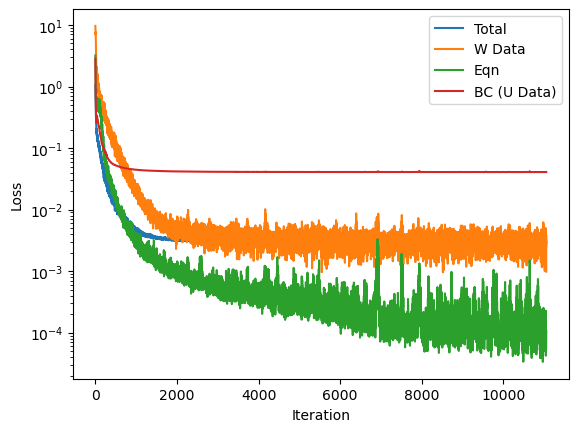

In [35]:
def plot_loss(loss):
  np_loss = np.array(loss)
  plt.semilogy(np_loss[:,0],label='Total')
  plt.semilogy(np_loss[:,1],label='W Data')
  plt.semilogy(np_loss[:,2],label='Eqn')
  plt.semilogy(np_loss[:,3],label='BC (U Data)')
  plt.legend()
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
plot_loss(loss1)

Now, it's time for the L-BFGS iteration.

In [ ]:
# set the training iteration
epoch2 = 10000
# re-sample the data and collocation points
data_l = dataf_l(key_lbfgs[1])

# training with L-bfgs
trained_params2, loss2 = lbfgs_optimizer(NN_loss, trained_params, data_l, epoch2)


Step: NaN | Loss: 2.9992e-03 | Loss_d: 3.0995e-03 Loss_e: 6.3675e-05 | Loss_b: 4.0803e-02
Step: NaN | Loss: 6.1840e-03 | Loss_d: 4.7363e-02 Loss_e: 2.0722e-03 | Loss_b: 4.1219e-02
Step: NaN | Loss: 2.9913e-03 | Loss_d: 2.9999e-03 Loss_e: 5.0826e-05 | Loss_b: 4.0799e-02
Step: NaN | Loss: 2.9901e-03 | Loss_d: 2.9861e-03 Loss_e: 4.8377e-05 | Loss_b: 4.0799e-02
Step: NaN | Loss: 2.9901e-03 | Loss_d: 2.9776e-03 Loss_e: 5.6223e-05 | Loss_b: 4.0799e-02
Step: NaN | Loss: 2.9892e-03 | Loss_d: 2.9725e-03 Loss_e: 4.8801e-05 | Loss_b: 4.0798e-02
Step: NaN | Loss: 2.9884e-03 | Loss_d: 2.9679e-03 Loss_e: 4.3429e-05 | Loss_b: 4.0797e-02
Step: NaN | Loss: 2.9908e-03 | Loss_d: 3.0020e-03 Loss_e: 3.9383e-05 | Loss_b: 4.0802e-02
Step: NaN | Loss: 2.9882e-03 | Loss_d: 2.9683e-03 Loss_e: 4.0069e-05 | Loss_b: 4.0797e-02
Step: NaN | Loss: 2.9878e-03 | Loss_d: 2.9627e-03 Loss_e: 4.0704e-05 | Loss_b: 4.0796e-02
Step: NaN | Loss: 2.9895e-03 | Loss_d: 2.9722e-03 Loss_e: 5.6302e-05 | Loss_b: 4.0796e-02
Step: NaN 

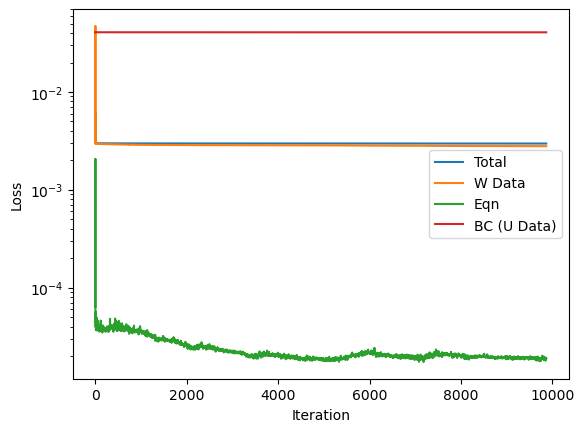

In [39]:
plot_loss(loss2)

L-BFGS doesn't help much here. 

Now we make the prediction.

In [41]:
# now lets make a prediction - this cell likely does not need to be changed
f_u = lambda x: pred_u(trained_params2, x)
f_gu = lambda x: vectgrad(f_u, x)[0][:, 0:10]
f_eqn = lambda x: gov_eqn(f_u, x, info)

x_pred = df_norm[['x','z']].values
uw_rho_pmu = f_u(x_pred)
# set the partition number
nsp = 4
# separate input into different partition to avoid GPU memory limit
x_psp = jnp.array_split(x_pred, nsp)
idxsp = jnp.arange(nsp).tolist()
# calculate the derivative of network output at the velocity-data positions
du_list = tree_map(lambda x: f_gu(x_psp[x]), idxsp)
# calculate the associated equation residue of the trained network
eqnterm_list = tree_map(lambda x: f_eqn(x_psp[x]), idxsp)
eqn_list = tree_map(lambda x: eqnterm_list[x][0], idxsp)
term_list = tree_map(lambda x: eqnterm_list[x][1], idxsp)
# combine the sub-group list into a long array
duw_rho_pmu = jnp.vstack(du_list)
eqn = jnp.vstack(eqn_list)
term = jnp.vstack(term_list)
results = {}
for i,key in enumerate(['u','w','rho','p','mu']):
    results[f'{key}_g'] = df_full[key].values
    results[f'{key}_p'] = uw_rho_pmu[:,i:i+1]*info[f'{key}_range'] + info[f'{key}_mean']
    results[f'{key}x_p'] = duw_rho_pmu[:,2*i:2*i+1] * info[f'{key}_range']/info['x_range']
    results[f'{key}z_p'] = duw_rho_pmu[:,2*i+1:2*i+2] * info[f'{key}_range']/info['z_range']
    
results['x'] = df_full['x'].values
results['z'] = df_full['z'].values


We also predict the terms

In [42]:
# predicting equation terms is unique to each model
term0 = info['rho_range']*9.81*info['z_range']/info['x_range']
results['e1']=eqn[:, 0:1] * term0
results['e11']=term[:, 0:1] * term0
results['e12']=term[:, 1:2] * term0
results['e13']=term[:, 2:3] * term0

term1 = info['rho_range']*9.81
results['e2']=eqn[:, 1:2] * term1
results['e21']=term[:, 3:4] * term1
results['e22']=term[:, 4:5] * term1
results['e23']=term[:, 5:6] * term1

Plotting the predictions below. We see how the pressure is "wrong" at the surface. Outside of that, the predictions are pretty good.

Text(0, 0.5, 'Predicted - Ground')

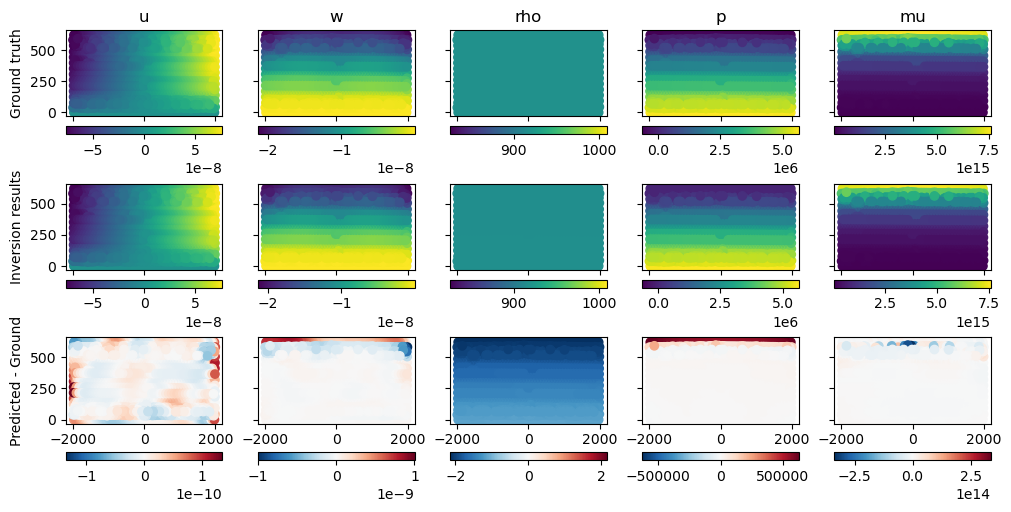

In [43]:
from matplotlib import colors

fig, axs = plt.subplots(figsize=(10,5),nrows=3,ncols=5,layout='constrained',sharex=True,sharey=True)
for i,key in enumerate(['u','w','rho','p','mu']):
    c = axs[0,i].scatter(results['x'],results['z'],c=results[f'{key}_g'])
    fig.colorbar(c, ax=axs[0, i], location='bottom')
    new_c = axs[1, i].scatter(results['x'], results['z'], 
                          c=results[f'{key}_p'], 
                          cmap=c.cmap, norm=c.norm)
    fig.colorbar(new_c, ax=axs[1, i], location='bottom')
    axs[0,i].set_title(f'{key}')

    diff = results[f'{key}_p'].flatten()-results[f'{key}_g']
    c = axs[2,i].scatter(results['x'],results['z'],c=diff,cmap='RdBu_r',norm=colors.CenteredNorm())
    fig.colorbar(c, ax=axs[2, i], location='bottom')

axs[0][0].set_ylabel('Ground truth')
axs[1][0].set_ylabel('Inversion results')
axs[2][0].set_ylabel('Predicted - Ground')



Likewise, the surface is the most erroneous in terms of the equation residues. Though not amazing, it looks like the physics are generally preserved, especially away from the surface.

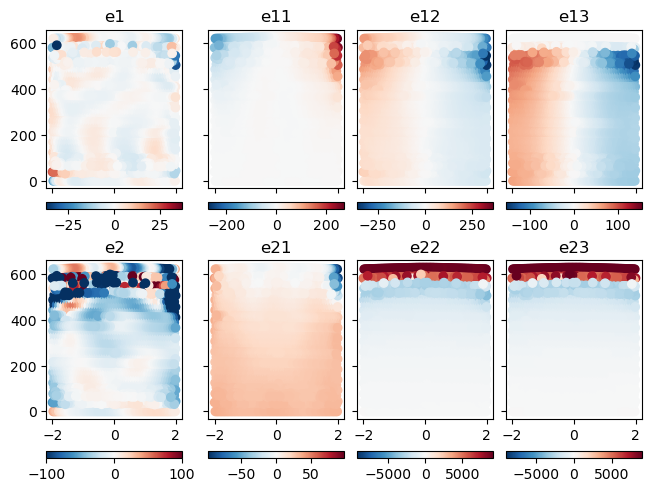

In [49]:
# check equation physics
from matplotlib import colors
fig, axs = plt.subplots(ncols=4,nrows=2,layout='constrained',sharex=True,sharey=True)
vmax = np.max(np.abs([results['e1'],results['e11'],results['e12'],results['e13'],
                     results['e2'],results['e21'],results['e22'],results['e23']]))

c=axs[0,0].scatter(results['x']/1000,results['z'],c=results['e1'],cmap='RdBu_r',norm=colors.CenteredNorm())#vmin=-vmax,vmax=vmax)
fig.colorbar(c, ax=axs[0,0], location='bottom')
axs[0,0].set_title('e1')
c = axs[1,0].scatter(results['x']/1000,results['z'],c=results['e2'],cmap='RdBu_r',vmin=-100,vmax=100)
fig.colorbar(c, ax=axs[1,0], location='bottom')
axs[1,0].set_title('e2')

for i in range(3):
    c = axs[0,i+1].scatter(results['x']/1000,results['z'],c=results[f'e1{i+1}'],cmap='RdBu_r',norm=colors.CenteredNorm())#vmin=-vmax,vmax=vmax)
    fig.colorbar(c, ax=axs[0,i+1], location='bottom')
    axs[0,i+1].set_title(f'e1{i+1}')

    c = axs[1,i+1].scatter(results['x']/1000,results['z'],c=results[f'e2{i+1}'],cmap='RdBu_r',norm=colors.CenteredNorm())#vmin=-vmax,vmax=vmax)
    fig.colorbar(c, ax=axs[1,i+1], location='bottom')
    axs[1,i+1].set_title(f'e2{i+1}')

## Try hiding p, mu

In [51]:
n_hl = 6
n_unit = 30
# initialize the weights and biases of the network
trained_params = init_pinns(keys[0], n_hl, n_unit)
pred_u = create_solution(df_bcs[0]) # need to modify as well


In [52]:
# create the loss function
NN_loss = create_loss_momentum(pred_u, gov_eqn, info, [1,1,1],alldata=False)
# calculate the initial loss and set it as the reference value for loss
NN_loss.lref = NN_loss(trained_params, data)[0]

In [53]:
# set the learning rate for Adam
lr = 1e-3
# set the training iteration
epoch1 = 10000

# training with Adam
trained_params, loss1 = adam_optimizer(keys_adam[1], NN_loss, trained_params, dataf, epoch1, lr=lr)


Step: 100 | Loss: 1.1085e-01 | Loss_d: 7.3029e-01 | Loss_e: 4.3353e-01 | Loss_b: 3.0697e-01
Step: 200 | Loss: 4.2137e-02 | Loss_d: 3.7378e-01 | Loss_e: 6.5264e-02 | Loss_b: 1.2005e-01
Step: 300 | Loss: 3.0508e-02 | Loss_d: 2.7788e-01 | Loss_e: 3.9824e-02 | Loss_b: 8.7107e-02
Step: 400 | Loss: 2.0136e-02 | Loss_d: 1.8499e-01 | Loss_e: 2.3347e-02 | Loss_b: 5.8848e-02
Step: 500 | Loss: 1.3060e-02 | Loss_d: 1.1273e-01 | Loss_e: 1.2508e-02 | Loss_b: 4.8048e-02
Step: 600 | Loss: 1.0651e-02 | Loss_d: 8.9831e-02 | Loss_e: 5.9059e-03 | Loss_b: 4.5593e-02
Step: 700 | Loss: 7.7737e-03 | Loss_d: 5.3120e-02 | Loss_e: 5.3047e-03 | Loss_b: 4.4723e-02
Step: 800 | Loss: 7.0463e-03 | Loss_d: 4.6114e-02 | Loss_e: 3.2798e-03 | Loss_b: 4.4102e-02
Step: 900 | Loss: 4.8405e-03 | Loss_d: 1.7912e-02 | Loss_e: 2.4934e-03 | Loss_b: 4.3822e-02
Step: 1000 | Loss: 4.4294e-03 | Loss_d: 1.3344e-02 | Loss_e: 2.0031e-03 | Loss_b: 4.3426e-02
Step: 1100 | Loss: 4.2665e-03 | Loss_d: 1.1366e-02 | Loss_e: 2.0532e-03 | Loss_

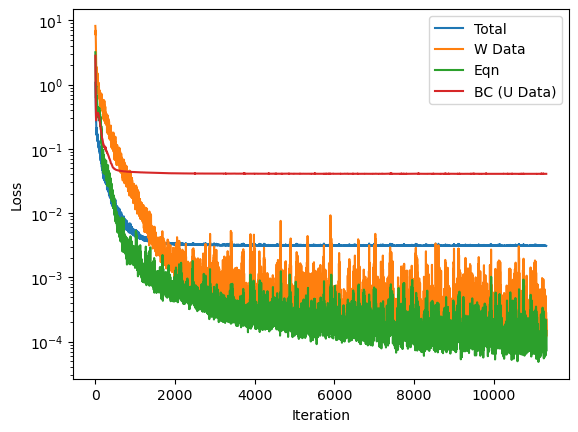

In [54]:
plot_loss(loss1)

In [55]:
# set the training iteration
epoch2 = 10000
# re-sample the data and collocation points
data_l = dataf_l(key_lbfgs[1])

# training with L-bfgs
trained_params2, loss2 = lbfgs_optimizer(NN_loss, trained_params, data_l, epoch2)


Step: NaN | Loss: 3.0969e-03 | Loss_d: 1.3179e-04 Loss_e: 1.1525e-04 | Loss_b: 4.0844e-02
Step: NaN | Loss: 4.2314e-03 | Loss_d: 1.2368e-02 Loss_e: 2.4990e-03 | Loss_b: 4.1278e-02
Step: NaN | Loss: 3.0921e-03 | Loss_d: 1.0809e-04 Loss_e: 8.0605e-05 | Loss_b: 4.0839e-02
Step: NaN | Loss: 3.0904e-03 | Loss_d: 9.6726e-05 Loss_e: 7.0305e-05 | Loss_b: 4.0838e-02
Step: NaN | Loss: 3.0982e-03 | Loss_d: 1.8353e-04 Loss_e: 8.2746e-05 | Loss_b: 4.0843e-02
Step: NaN | Loss: 3.0900e-03 | Loss_d: 9.6484e-05 Loss_e: 6.6451e-05 | Loss_b: 4.0838e-02
Step: NaN | Loss: 3.0895e-03 | Loss_d: 9.3665e-05 Loss_e: 6.1721e-05 | Loss_b: 4.0838e-02
Step: NaN | Loss: 3.0895e-03 | Loss_d: 9.8083e-05 Loss_e: 5.5434e-05 | Loss_b: 4.0840e-02
Step: NaN | Loss: 3.0890e-03 | Loss_d: 9.2744e-05 Loss_e: 5.6039e-05 | Loss_b: 4.0839e-02
Step: NaN | Loss: 3.0887e-03 | Loss_d: 8.9565e-05 Loss_e: 5.3931e-05 | Loss_b: 4.0839e-02
Step: NaN | Loss: 3.0901e-03 | Loss_d: 1.0347e-04 Loss_e: 5.7592e-05 | Loss_b: 4.0841e-02
Step: NaN 

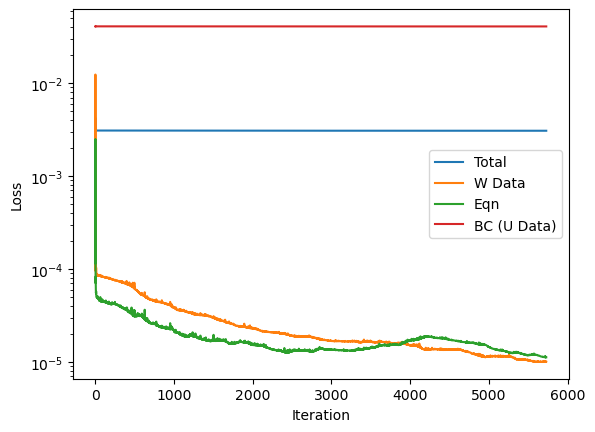

In [56]:
plot_loss(loss2)

In [58]:
# now lets make a prediction - this cell likely does not need to be changed
f_u = lambda x: pred_u(trained_params2, x)
f_gu = lambda x: vectgrad(f_u, x)[0][:, 0:10]
f_eqn = lambda x: gov_eqn(f_u, x, info)

x_pred = df_norm[['x','z']].values
uw_rho_pmu = f_u(x_pred)
# set the partition number
nsp = 4
# separate input into different partition to avoid GPU memory limit
x_psp = jnp.array_split(x_pred, nsp)
idxsp = jnp.arange(nsp).tolist()
# calculate the derivative of network output at the velocity-data positions
du_list = tree_map(lambda x: f_gu(x_psp[x]), idxsp)
# calculate the associated equation residue of the trained network
eqnterm_list = tree_map(lambda x: f_eqn(x_psp[x]), idxsp)
eqn_list = tree_map(lambda x: eqnterm_list[x][0], idxsp)
term_list = tree_map(lambda x: eqnterm_list[x][1], idxsp)
# combine the sub-group list into a long array
duw_rho_pmu = jnp.vstack(du_list)
eqn = jnp.vstack(eqn_list)
term = jnp.vstack(term_list)
results = {}
for i,key in enumerate(['u','w','rho','p','mu']):
    results[f'{key}_g'] = df_full[key].values
    results[f'{key}_p'] = uw_rho_pmu[:,i:i+1]*info[f'{key}_range'] + info[f'{key}_mean']
    results[f'{key}x_p'] = duw_rho_pmu[:,2*i:2*i+1] * info[f'{key}_range']/info['x_range']
    results[f'{key}z_p'] = duw_rho_pmu[:,2*i+1:2*i+2] * info[f'{key}_range']/info['z_range']
    
results['x'] = df_full['x'].values
results['z'] = df_full['z'].values

term0 = info['rho_range']*9.81*info['z_range']/info['x_range']
results['e1']=eqn[:, 0:1] * term0
results['e11']=term[:, 0:1] * term0
results['e12']=term[:, 1:2] * term0
results['e13']=term[:, 2:3] * term0

term1 = info['rho_range']*9.81
results['e2']=eqn[:, 1:2] * term1
results['e21']=term[:, 3:4] * term1
results['e22']=term[:, 4:5] * term1
results['e23']=term[:, 5:6] * term1

Text(0, 0.5, 'Predicted - Ground')

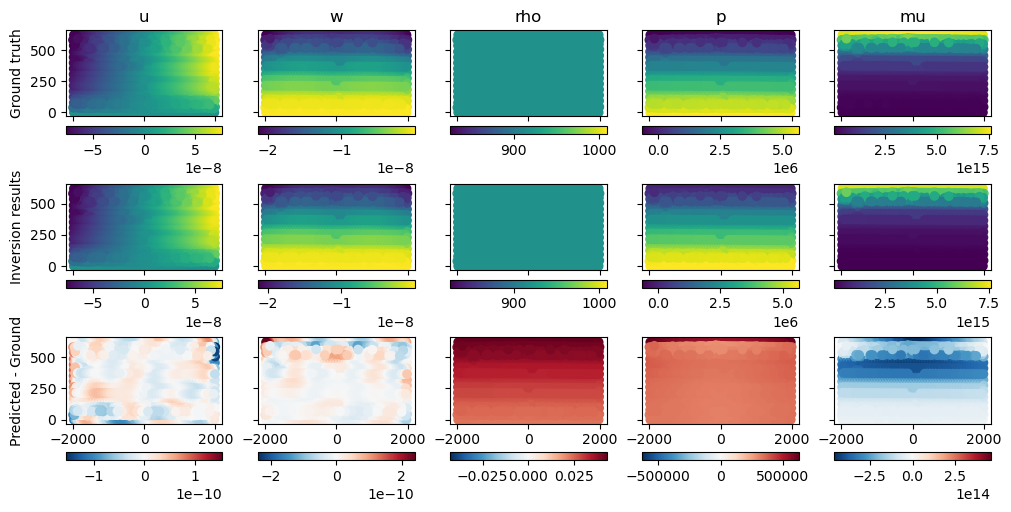

In [59]:
from matplotlib import colors

fig, axs = plt.subplots(figsize=(10,5),nrows=3,ncols=5,layout='constrained',sharex=True,sharey=True)
for i,key in enumerate(['u','w','rho','p','mu']):
    c = axs[0,i].scatter(results['x'],results['z'],c=results[f'{key}_g'])
    fig.colorbar(c, ax=axs[0, i], location='bottom')
    new_c = axs[1, i].scatter(results['x'], results['z'], 
                          c=results[f'{key}_p'], 
                          cmap=c.cmap, norm=c.norm)
    fig.colorbar(new_c, ax=axs[1, i], location='bottom')
    axs[0,i].set_title(f'{key}')

    diff = results[f'{key}_p'].flatten()-results[f'{key}_g']
    c = axs[2,i].scatter(results['x'],results['z'],c=diff,cmap='RdBu_r',norm=colors.CenteredNorm())
    fig.colorbar(c, ax=axs[2, i], location='bottom')

axs[0][0].set_ylabel('Ground truth')
axs[1][0].set_ylabel('Inversion results')
axs[2][0].set_ylabel('Predicted - Ground')



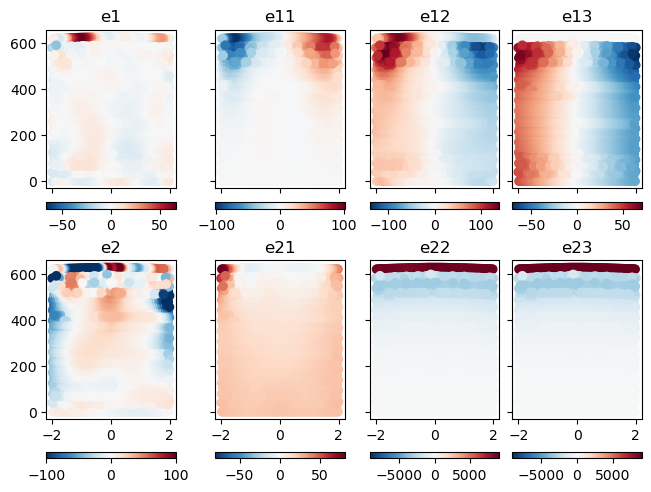

In [60]:
# check equation physics
from matplotlib import colors
fig, axs = plt.subplots(ncols=4,nrows=2,layout='constrained',sharex=True,sharey=True)
vmax = np.max(np.abs([results['e1'],results['e11'],results['e12'],results['e13'],
                     results['e2'],results['e21'],results['e22'],results['e23']]))

c=axs[0,0].scatter(results['x']/1000,results['z'],c=results['e1'],cmap='RdBu_r',norm=colors.CenteredNorm())#vmin=-vmax,vmax=vmax)
fig.colorbar(c, ax=axs[0,0], location='bottom')
axs[0,0].set_title('e1')
c = axs[1,0].scatter(results['x']/1000,results['z'],c=results['e2'],cmap='RdBu_r',vmin=-100,vmax=100)
fig.colorbar(c, ax=axs[1,0], location='bottom')
axs[1,0].set_title('e2')

for i in range(3):
    c = axs[0,i+1].scatter(results['x']/1000,results['z'],c=results[f'e1{i+1}'],cmap='RdBu_r',norm=colors.CenteredNorm())#vmin=-vmax,vmax=vmax)
    fig.colorbar(c, ax=axs[0,i+1], location='bottom')
    axs[0,i+1].set_title(f'e1{i+1}')

    c = axs[1,i+1].scatter(results['x']/1000,results['z'],c=results[f'e2{i+1}'],cmap='RdBu_r',norm=colors.CenteredNorm())#vmin=-vmax,vmax=vmax)
    fig.colorbar(c, ax=axs[1,i+1], location='bottom')
    axs[1,i+1].set_title(f'e2{i+1}')